# INFO 2950 Final Project - Phase II

## Research Questions:

Questions: Can we predict the probability that a voting-eligible person living in the United States will vote based on the year and their state’s voter turnout and population density, literacy rate, age, race, and income? Are there any noticeable patterns or correlations between each of these variables (Ex. does a higher literacy rate increase the likelihood that an person votes)? How do these voting trends and correlations change over time (Ex. as literacy rates increases over time, do voting trends follow)? 

The main differentiating feature of our project is that we will be conducting this analysis on demographics and voting patterns by each state and each election year, instead of nationally.

In this assignment, we will train a multivariable regression model to determine if we can reliably predict how likely a voter is to vote in their general (mid-term) election (so every two years) given the stated factors above. We set out to analyze how socioeconomic factors as well as the changing political climate over the year has affected Americans’ willingness to vote. To narrow the focus of our project, we're only looking at data from the 2000 election to the 2022 election (every two years), which allows us to connect voting data to other datasets that would likely be more available for modern years (it's difficult to find each state's literacy rate for every year dating back to 1950, for example).

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import duckdb

## Data Descriptions:

The data we use comes from a number of different sources. Each of these dataframes is then combined (using the appropriate merge commands) into a single dataframe, which is then easier to conduct analysis on (and visualize). This merged data frame will have the following columns: TODO

Here are short descriptions of the data sources:
 - Voter Turnout Data: https://www.electproject.org/election-data/voter-turnout-data
    - This website was created by Michael P. McDonald, a professor of political science at the University of Florida. It is just a host for the data displayed on https://election.lab.ufl.edu/voter-turnout/ (so a reputable source). To get the data in the form we wanted, we downloaded 10 CSVs from this site (one for each election) and merged them vertically. The data is usable under the Creative Commons Attribution 3.0 Unported License (with proper citation).

 - Bachelor's Degree or Higher by State: https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od=2009-01-01# 
 - Real Median Household Income by State: https://fred.stlouisfed.org/release/tables?rid=249&eid=259515&od=# 
 - Resident Population by State: https://fred.stlouisfed.org/release/tables?rid=118&eid=259194
   - This website is FRED, which is one of the most reputable sources for economic data. To get the data in the form we wanted (merged), we used an importHTML formula in Google Sheets and downloaded that data as a CSV. The data is usable with proper citation, according to the legal notice on the site.

 - Race Makeup by State: https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
 - Age by State: https://www.kff.org/other/state-indicator/distribution-by-age/?dataView=1&activeTab=graph&currentTimeframe=0&startTimeframe=13&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
    - This website is KFF, which hosts the "most up-to-date and accurate information on health policy". We downloaded the data as a single CSV from this site, and imported in directly into our project. The data is usable with proper citation, according to the citation page on the site.

 - Area by State: https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
   - This website is the US Census Bureau, which is as formal as it gets for data about US demographics. The data is usable with proper citation, according to the citation page on the site.


## Data Cleaning:

To work towards our goal of a single merged data frame, we need to load in each CSV and clean it before merging everything together using SQL.

We started by downloading the Voter Turnout Data from [electproject.org ](https://www.electproject.org/election-data/voter-turnout-data) and using Excel to quickly fix errors in the data. 

These errors included certain CSVs (2016, 2018, 2020, and 2022) containing different names for the same column values, which would cause errors when trying to vertically join the data. There were also a few states that had '*' at the end of their names, which corresponded to certain (irrelevant for our use) notes that were held at the bottom of the CSV. We removed those in Excel, and deleted the rows containing the notes as well, since pandas would read those in as additional rows in our dataframe.

When reading in the data from CSV form, we found it easy to skip rows at index 0 and 2, corresponding to unneeded headers and the State 'United States' in the data. Note that if we need data for the whole US later, we can make it ourselves using simple grouping and addition. We also parsed in commas to read the data.

Since a number of columns were not needed, we used an SQL statement to rename columns to shorter, more descriptive names and added two columns for percentages as floats. There are some NaNs in the data, but since this is going to be the left most data set in our merge calls, we want there to be a value for each state in each year, so we'll leave them as is for now.

As a sanity check, since D.C. is included as a state, we should have 51 states * 11 elections = 561 rows.

In [21]:
#read csv, skip rows 0 and 2 to remove headers and 'United States'
#including thousands to parse commas
election_year_data_2000 = pd.read_csv('data/election_2000.csv', skiprows=[0,2] , thousands=",")
election_year_data_2000['Year'] = 2000

#repeat the above for each election year
election_year_data_2002 = pd.read_csv('data/election_2002.csv', skiprows=[0,2] , thousands=",")
election_year_data_2002['Year'] = 2002

election_year_data_2004 = pd.read_csv('data/election_2004.csv', skiprows=[0,2] , thousands=",")
election_year_data_2004['Year'] = 2004

election_year_data_2006 = pd.read_csv('data/election_2006.csv', skiprows=[0,2] , thousands=",")
election_year_data_2006['Year'] = 2006

election_year_data_2008 = pd.read_csv('data/election_2008.csv', skiprows=[0,2] , thousands=",")
election_year_data_2008['Year'] = 2008

election_year_data_2010 = pd.read_csv('data/election_2010.csv', skiprows=[0,2] , thousands=",")
election_year_data_2010['Year'] = 2010

election_year_data_2012 = pd.read_csv('data/election_2012.csv', skiprows=[0,2] , thousands=",")
election_year_data_2012['Year'] = 2012

election_year_data_2014 = pd.read_csv('data/election_2014.csv', skiprows=[0,2] , thousands=",")
election_year_data_2014['Year'] = 2014

election_year_data_2016 = pd.read_csv('data/election_2016.csv', skiprows=[0,2] , thousands=",")
election_year_data_2016['Year'] = 2016

election_year_data_2018 = pd.read_csv('data/election_2018.csv', skiprows=[0,2] , thousands=",")
election_year_data_2018['Year'] = 2018

election_year_data_2020 = pd.read_csv('data/election_2020.csv', skiprows=[0,2] , thousands=",")
election_year_data_2020['Year'] = 2020

election_year_data_2022 = pd.read_csv('data/election_2022.csv', skiprows=[0,2] , thousands=",")
election_year_data_2022['Year'] = 2022

#concat the data (vertical join), ignoring the index
election_year_data = pd.concat([election_year_data_2000,
                                election_year_data_2002,
                                election_year_data_2004,
                                election_year_data_2006,
                                election_year_data_2008,
                                election_year_data_2010,
                                election_year_data_2012,
                                election_year_data_2014, 
                                election_year_data_2016, 
                                election_year_data_2018,
                                election_year_data_2020,
                                election_year_data_2022],ignore_index=True)
#print the shape as a sanity check, should number of rows should be 612 = 12*51
print(election_year_data.shape)

#use SQL to change certain column names and create 2 new columns for percentages
election_year_data = duckdb.sql("""SELECT "Unnamed: 0" AS State, Year, "Total Ballots Counted" AS TotalBallots,
                                "Voting-Eligible Population (VEP)" AS VotingEligiblePopulation, 
                                "Voting-Age Population (VAP)" AS VotingAgePopulation, 
                                TotalBallots/VotingEligiblePopulation AS PercentVotingEligibleVotes,
                                TotalBallots/VotingAgePopulation AS PercentVotingAgeVotes
                                FROM election_year_data""").df()

#print the dataset to verify completion and accuracy
election_year_data


(612, 17)


,State,Year,TotalBallots,VotingEligiblePopulation,VotingAgePopulation,PercentVotingEligibleVotes,PercentVotingAgeVotes
0,Alabama,2000,NaN,3241682,3334576,NaN,NaN
1,Alaska,2000,287825.0,419111,440296,0.686751,0.653708
2,Arizona,2000,1559520.0,3357701,3816498,0.464461,0.408626
3,Arkansas,2000,NaN,1925961,2001774,NaN,NaN
4,California,2000,11142843.0,19685258,24867252,0.566050,0.448093
...,...,...,...,...,...,...,...
607,Virginia,2022,3021956.0,6348891,6836463,0.475982,0.442035
608,Washington,2022,3067686.0,5543001,6164761,0.553434,0.497616
609,West Virginia,2022,494753.0,1396169,1423003,0.354365,0.347682
610,Wisconsin,2022,2673154.0,4467396,4655496,0.598370,0.574193


We're now loading in data about the education level (specifically, the percent of the population that has a Bachelor's degree or higher) of each state in each election year. This was scraped using importHTML in Google Sheets from [FRED](https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od=2008-01-01#).

As a general overview of how web scraping in Google Sheets works, we supply a link to the importHTML formula, specify what type of data type we want to parse ('table' in this case), and the number (what table number to scrape) as the final parameter. We can then copy the column we need (% bachelor's) into a new sheet, aligning it with the state the data corresponds to. Note that the link to the FRED website uses a date as a parameter, meaning we can treat our importHTML function as a kind of API. Essentially, we can edit the date to the specific year we want, and the data will automatically be updated in Google Sheets, which allows us to do a bunch of copy-pasting of data, without ever having to download and merge CSVs until we have our final sheet. This is a kind of web scraping that is quasi-automatic and similar to an API call, and significantly easier than downloading and merging 10 CSVs in Python. Note that this is only possible on FRED sites, since they display the data in tables on the web, rather than the other sites which don't do the same (or do it in a way we can't web scrape).

Unfortunately, we don't have data pre-2006 for each state. When we merge everything together, we'll use a left join and deal with the NaNs later.

The data from FRED comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 8 columns/years we want to melt, we should end up with 8 elections * 51 states (D.C.) = 408 rows.

Most of the code parsing data from FRED will follow this form.

In [20]:
#read in the data
education = pd.read_csv('data/education.csv', thousands=",")
#melt the data into long form
education = education.melt(id_vars=['Name'],value_name="Education",var_name="Year")
#printing the shape should yield 408 rows
print(education.shape)
#print education to verify
education

(408, 3)


,Name,Year,Education
0,Alabama,2006,21.1
1,Alaska,2006,26.9
2,Arizona,2006,25.5
3,Arkansas,2006,18.2
4,California,2006,29.0
...,...,...,...
403,Virginia,2022,42.2
404,Washington,2022,39.5
405,West Virginia,2022,24.8
406,Wisconsin,2022,33.2


We're now loading in data about the income level (specifically, the Real Median Household Income by State) of each state in each election year. This was scraped using importHTML in Google Sheets from [FRED](https://fred.stlouisfed.org/release/tables?rid=249&eid=259515&od=#).

We followed the same steps as the above (education) to parse the data before reading it into Python.

The data from FRED comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 12 columns/years we want to melt, we should end up with 12 elections * 51 states (D.C.) = 612 rows.

In [23]:
#read in the csv
income = pd.read_csv('data/income.csv', thousands=",")
#melt the data into long form
income = income.melt(id_vars=['Name'],value_name="Income",var_name="Year")
#print the shape of the dataframe as a sanity check, should be 612 rows
print(income.shape)
#print the data frame to make sure everything looks right
income

(612, 3)


,Name,Year,Income
0,Alabama,2000,4452.170
1,Alaska,2000,627.963
2,Arizona,2000,5160.590
3,Arkansas,2000,2678.590
4,California,2000,33987.980
...,...,...,...
607,Virginia,2022,8679.100
608,Washington,2022,7784.480
609,West Virginia,2022,1774.040
610,Wisconsin,2022,5890.540


We're now loading in data about the racial demographics from [KFF.org](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D). To obtain a single numeric value for something as abstract as "diversity", we simply found the percent of the population that is white, which we can then use to obtain the percent of population that is a minority racial group, if needed. This is a big abstraction to make, but needed to obtain quantitative data relatively simply.

The initial CSV has the U.S. as a row, which we're excluding (unfortunately, since the values here are percentages, we can't re-derive this, but we can easily come back to this point to include the US if needed). Also unfortunate is the fact that 2020 is not included in this data.

The data from KFF comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 14 columns/years we want to melt, we should end up with 14 elections * 51 states (D.C.) = 714 rows.

However, the since the original column names had _ _ White appended to the year (i.e. 2008__White), this values bleed into the column values for the 'Year' column we just created. We can't have this, though, since we need to merge this data back based on Location and Year. So, we'll use a simple REGEX formula to replace everything before the "_ _" with nothing. This way, the Year column just contains a single number. Note that we're doing this after we melt, since it's easier to rename all the values in a single column then rename 14 different columns.

In [26]:
#read in the CSV, skipping the row for the US as a whole
diversity = pd.read_csv('data/diversity.csv', thousands=",", skiprows=[1])
#melt the data into long form
diversity = diversity.melt(id_vars=['Location'],value_name="Percent White",var_name="Year")
#print the shape as a sanity check, should have 714 rows
print(diversity.shape)
#fix the year column by only looking at the stuff before __
diversity['Year'] = diversity['Year'].replace(r'(.*)__.*', r'\1', regex=True)
#print out the data frame to ensure correctness
diversity

(714, 3)


,Location,Year,Percent White
0,Alabama,2008,0.68670
1,Alaska,2008,0.66160
2,Arizona,2008,0.58220
3,Arkansas,2008,0.75710
4,California,2008,0.42030
...,...,...,...
709,Virginia,2022,0.58904
710,Washington,2022,0.63597
711,West Virginia,2022,0.90436
712,Wisconsin,2022,0.79052


The next step is to load in data about the mean age for each state. This data is also from [KFF.org](https://www.kff.org/other/state-indicator/distribution-by-age/?dataView=1&activeTab=graph&currentTimeframe=0&startTimeframe=13&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D). 

Unfortunately, the data doesn't contain a single number for median or mean age, but includes the number of people in a number of age ranges, as well as the total number of people in the state (for each year). So, we'll need to manually calculate (estimate, really) this value for each state in each year. It wouldn't be efficient to copy and paste creating a new column 14 times (making a new column for each year and there are 14 years), so we can speed up the process using a for loop.

The loop cycles through each of the years present in the data (unfortunately, no 2020). For each year, 

The data from KFF comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 14 columns/years we want to melt, we should end up with 14 elections * 51 states (D.C.) = 714 rows.

However, the since the original column names had _ _ White appended to the year (i.e. 2008__White), this values bleed into the column values for the 'Year' column we just created. We can't have this, though, since we need to merge this data back based on Location and Year. So, we'll use a simple REGEX formula to replace everything before the "_ _" with nothing. This way, the Year column just contains a single number. Note that we're doing this after we melt, since it's easier to rename all the values in a single column then rename 14 different columns.

In [159]:
age = pd.read_csv('data/age.csv', thousands=",", skiprows=[0,1,3])

list_years = np.arange(2008,2020)
list_years = np.append(list_years, [2021,2022])

for i in list_years:
    age[str(i)+'__EstMeanAge'] = ((age[str(i)+'__Children 0-18']*9) + (age[str(i)+'__Adults 19-25']*22) + (age[str(i)+'__Adults 26-34']*30)
                                  + (age[str(i)+'__Adults 35-54']*45) + (age[str(i)+'__Adults 55-64']*60) + (age[str(i)+'__65+']*75))
    age[str(i)+'__EstMeanAge'] = (age[str(i)+'__EstMeanAge']) / (age[str(i)+'__Total'])
    

age = age.loc[:,['Location','2008__EstMeanAge','2012__EstMeanAge','2012__EstMeanAge','2014__EstMeanAge',
                  '2016__EstMeanAge','2018__EstMeanAge','2022__EstMeanAge']]
age = age.melt(id_vars=['Location'],value_name="AverageAge",var_name="Year")
age['Year'] = age['Year'].replace(r'(.*)__.*', r'\1', regex=True)
print(diversity.shape)
age

(714, 3)


,Location,Year,AverageAge
0,Alabama,2008,38.331772
1,Alaska,2008,34.782343
2,Arizona,2008,37.247258
3,Arkansas,2008,38.450157
4,California,2008,36.442932
...,...,...,...
359,Washington,2022,40.752680
360,West Virginia,2022,43.466837
361,Wisconsin,2022,41.863187
362,Wyoming,2022,41.322661


We're now loading in data about the education level of each state in each election year. As a sanity check, we should have 11*51 = 612 rows.

In [187]:
population = pd.read_csv('data/population.csv', thousands=",")
population = population.melt(id_vars=['Name'],value_name="Population",var_name="Year")
print(population.shape)

area = pd.read_csv('data/area_by_state.csv', thousands=",", skiprows=[1])
area = area.iloc[0:56,]

population_density = duckdb.sql("""SELECT Name,Year,Population,Area FROM population LEFT JOIN area ON population.Name = area.State""").df()

population_density['PopulationDensity'] = 1000*population_density['Population']/population_density['Area']
population_density

(612, 3)


,Name,Year,Population,Area,PopulationDensity
0,Alaska,2000,627.963,665384,0.943760
1,Arizona,2000,5160.590,113990,45.272305
2,Arkansas,2000,2678.590,53179,50.369319
3,California,2000,33987.980,163695,207.629922
4,Colorado,2000,4326.920,104094,41.567429
...,...,...,...,...,...
607,Maryland,2018,6042.150,12406,487.034499
608,Alabama,2020,5031.860,52420,95.991225
609,Maryland,2020,6173.690,12406,497.637433
610,Alabama,2022,5073.900,52420,96.793209


In [222]:
#merging everything together

election_demographics = duckdb.sql("""SELECT * FROM election_year_data
                                   LEFT JOIN education ON election_year_data.State = education.Name AND election_year_data.Year = education.Year""").df()

election_demographics = duckdb.sql("""SELECT * FROM election_demographics
                                   LEFT JOIN income ON election_demographics.State = income.Name AND election_demographics.Year = income.Year""").df()

election_demographics = duckdb.sql("""SELECT * FROM election_demographics
                                   LEFT JOIN income ON election_demographics.State = income.Name AND election_demographics.Year = income.Year""").df()

election_demographics

,State,VEP Total Ballots Counted,VEP Highest Office,VAP Highest Office,Total Ballots Counted,Highest Office,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,Year,State Abv,VEP Highest Office.1,Name,Year_1,Income
0,Alabama,None,51.6%,50.1%,NaN,1672551.0,3241682,3334576,1.5%,26225,40178,5484,51798,NaN,2000,None,None,Alabama,2000,4452.170
1,Alaska,68.7%,68.1%,65.0%,287825.0,285560.0,419111,440296,3.4%,4173,4779,525,7088,NaN,2000,None,None,Alaska,2000,627.963
2,Arizona,46.4%,45.6%,40.2%,1559520.0,1532016.0,3357701,3816498,10.3%,26510,59810,3474,59889,NaN,2000,None,None,Arizona,2000,5160.590
3,Arkansas,None,47.9%,46.0%,NaN,921781.0,1925961,2001774,2.3%,11915,28409,8659,34779,NaN,2000,None,None,Arkansas,2000,2678.590
4,California,56.6%,55.7%,44.1%,11142843.0,10965849.0,19685258,24867252,18.8%,163001,0,117647,280648,NaN,2000,None,None,California,2000,33987.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,Washington,43.1%,41.2%,37.1%,2124330.0,2029189.0,4928407,5479396,8.4%,17345,94112,9880,79928,NaN,2014,WA,None,Washington,2014,7057.530
557,West Virginia,42.5%,41.7%,None,597149.0,586034.0,1404206,1429959,0.8%,7137,6523,3550,14405,NaN,2018,WV,None,West Virginia,2018,1805.950
558,Washington,76.2%,4087631,None,4116894.0,NaN,5405804,6034791,9.1%,18777,76672,12222,78536,NaN,2020,WA,75.6%,Washington,2020,7724.570
559,Colorado,58.3%,None,None,2540666.0,NaN,4357176,4642930,5.8%,14990,0,0,14990,NaN,2022,CO,None,Colorado,2022,5841.040


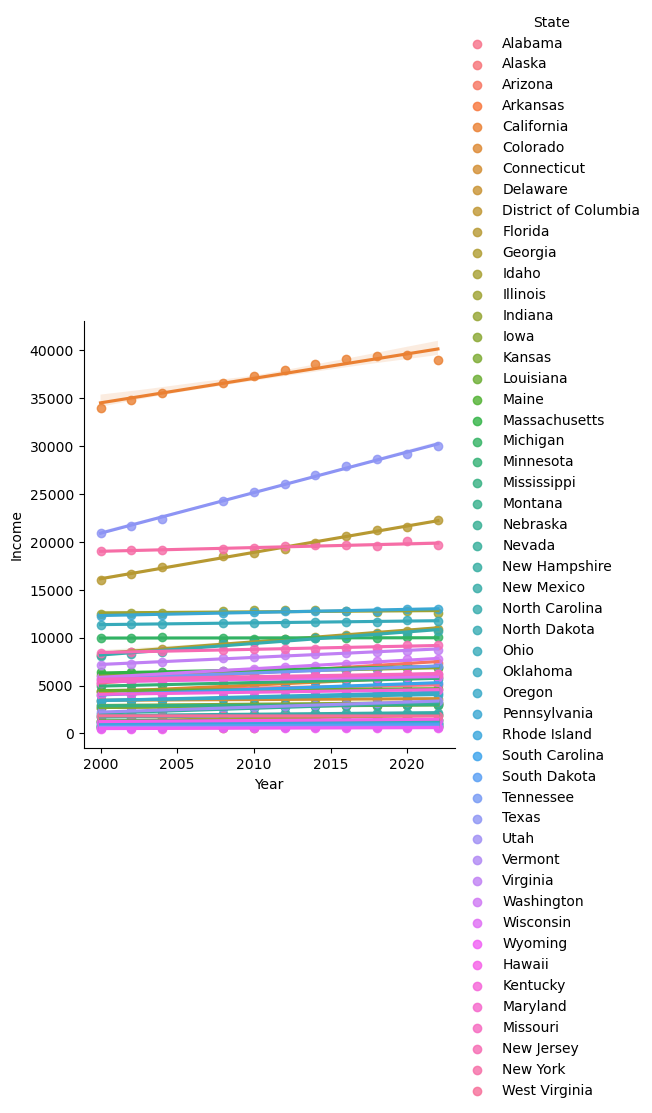

In [227]:
sns.lmplot(data = election_demographics, x = 'Year', y= 'Income', hue = 'State')
plt.show()